## Motor erf HNN-modeling and optimization

Motor ERF from button press experiment -response time-locked, from Bonaiuto et al. 2018

HNN-core parameters optimization protocol from: https://jonescompneurolab.github.io/hnn-core

In [1]:
import os
import copy
from model_merf import set_params
from preprocessing import preprocess_erf
from hnn_core import read_dipole
from hnn_core import (law_2021_model, jones_2009_model)
from hnn_core import (read_dipole, simulate_dipole, MPIBackend, JoblibBackend)
from custom_optim import SequentialOptimizer
from hnn_core.dipole import (average_dipoles, plot_dipole)
from matplotlib import pyplot as plt

In [2]:
%env OMPI_TMPDIR=/scratch
%env TMPDIR=/scratch

env: OMPI_TMPDIR=/scratch
env: TMPDIR=/scratch


In [3]:
%env TMPDIR

'/scratch'

In [4]:
base_data_dir='./data'
subject='sub-001'
session='ses-01'
c_idx=3
epoch='motor'
s_rate = 600
data_dir=os.path.join(base_data_dir, subject, session, f'{subject}_{session}_c{c_idx}_{epoch}_model_inv')

hnn_dir=os.path.join(base_data_dir, subject, session, f'{subject}_{session}_c{c_idx}_{epoch}_hnn')

print(data_dir)

./data/sub-001/ses-01/sub-001_ses-01_c3_motor_model_inv


#### Loading and preprocessing of the merfs
turn if inverted dipole

In [5]:
preprocess_erf(data_dir, hnn_dir, s_rate, 18)

Setting up low-pass filter at 18 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 18.00 Hz: -6.02 dB

Processed sub-001_ses-01_c3_motor_model_inv. ERF was flipped. Filtered at 18 Saved to ./data/sub-001/ses-01/sub-001_ses-01_c3_motor_hnn/sub-001_ses-01_c3_motor_model_inv_erf.txt


In [6]:
exp_dpl = read_dipole(os.path.join(hnn_dir, f'{subject}_{session}_c{c_idx}_{epoch}_model_inv_erf.txt'))

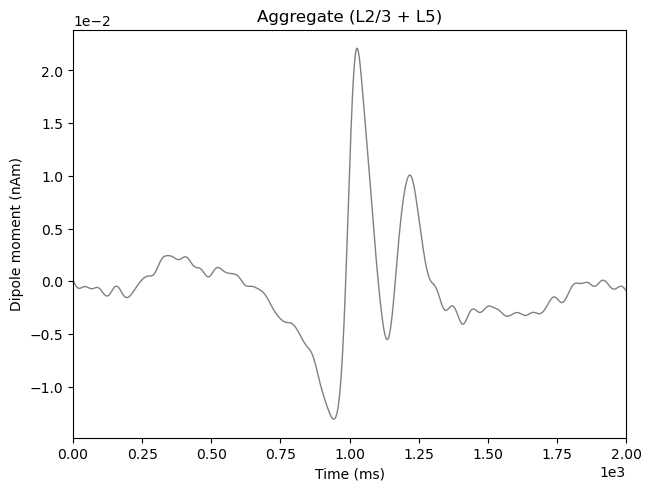

In [7]:
_ = exp_dpl.plot()

#### Optimization

In [23]:
constraints = dict({'rydist1_ampa_L2_basket': (0.0001, 0.001),
                    'rydist1_ampa_L2_pyramidal': (0.0001, 0.001),
                    'rydist1_ampa_L5_pyramidal': (0.0001, 0.001),
                    'rydist1_mu': (500., 800.),
                    'rydist1_sigma': (30., 70.),
    
                    'evdist2_ampa_L2_basket': (0.01, 1.),
                    'evdist2_ampa_L2_pyramidal': (0.01, 1.),
                    'evdist2_ampa_L5_pyramidal': (0.01, 1.),
                    'evdist2_nmda_L2_basket': (0.01, 1.),
                    'evdist2_nmda_L2_pyramidal': (0.01, 1.),
                    'evdist2_nmda_L5_pyramidal': (0.01, 1.),
                    'evdist2_mu': (900., 970.),
                    'evdist2_sigma': (10., 40.),

                    'evprox1_ampa_L2_basket': (0.01, 1.),
                    'evprox1_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox1_ampa_L5_basket': (0.01, 1.),
                    'evprox1_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L2_basket': (0.01, 1.),
                    'evprox1_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox1_nmda_L5_basket': (0.01, 1.),
                    'evprox1_nmda_L5_pyramidal': (0.01, 1.),
                    'evprox1_mu': (1000., 1100.),
                    'evprox1_sigma': (2., 30.),

                    'evprox2_ampa_L2_basket': (0.01, 1.),
                    'evprox2_ampa_L2_pyramidal': (0.01, 1.),
                    'evprox2_ampa_L5_basket': (0.01, 1.),
                    'evprox2_ampa_L5_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L2_basket': (0.01, 1.),
                    'evprox2_nmda_L2_pyramidal': (0.01, 1.),
                    'evprox2_nmda_L5_basket': (0.01, 1.),
                    'evprox2_nmda_L5_pyramidal': (0.01, 1.),
                    'evprox2_mu': (1100., 1300.),
                    'evprox2_sigma': (2., 30.),
                   })

In [9]:
import json
with open('initial_params_v2.json', 'r') as f:
    initial_params = json.load(f)

In [41]:
initial_params = opt_params

In [19]:
n_trials = 5
tstop = 2000
window_len, scaling_factor = 30, 1 #estimated 250,000 cells

net = law_2021_model(None)
net = set_params(net, initial_params, hypo=2) #specify the hypothesis you optimize 

with MPIBackend(n_procs=50, mpi_cmd='mpiexec'):
#with JoblibBackend(n_jobs=50):
    init_dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)

for dpl in init_dpl:
    dpl.smooth(window_len).scale(scaling_factor)

avg_dpl_init = average_dipoles(init_dpl)

Setting parameters: {'rydist1_ampa_L2_basket': 0.0011, 'rydist1_ampa_L2_pyramidal': 0.0027, 'rydist1_ampa_L5_pyramidal': 0.0028, 'rydist1_mu': 734.0, 'rydist1_sigma': 57.6, 'evdist2_ampa_L2_basket': 0.6121579707704913, 'evdist2_ampa_L2_pyramidal': 0.6245584647492026, 'evdist2_ampa_L5_pyramidal': 0.973528322653582, 'evdist2_nmda_L2_basket': 0.57986418705435, 'evdist2_nmda_L2_pyramidal': 0.5721657338349071, 'evdist2_nmda_L5_pyramidal': 0.17769272341378614, 'evdist2_mu': 905.7168241599677, 'evdist2_sigma': 31.742683478914483, 'evprox1_ampa_L2_basket': 0.33628891212190765, 'evprox1_ampa_L2_pyramidal': 0.1966689920786076, 'evprox1_ampa_L5_basket': 0.24782769133545213, 'evprox1_ampa_L5_pyramidal': 0.6316976139923263, 'evprox1_nmda_L2_basket': 0.12023257681765015, 'evprox1_nmda_L2_pyramidal': 0.5582628412600553, 'evprox1_nmda_L5_basket': 0.9959616253769533, 'evprox1_nmda_L5_pyramidal': 0.05209955437498684, 'evprox1_mu': 1012.7509215159755, 'evprox1_sigma': 10.739724779230636, 'evprox2_ampa_L2

/home/sgailhard/miniconda3/envs/hnn/lib/python3.12/site-packages/hnn_core/parallel_backends.py:891: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


MPI will run 5 trial(s) sequentially by distributing network neurons over 50 processes.
numprocs=50
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWar

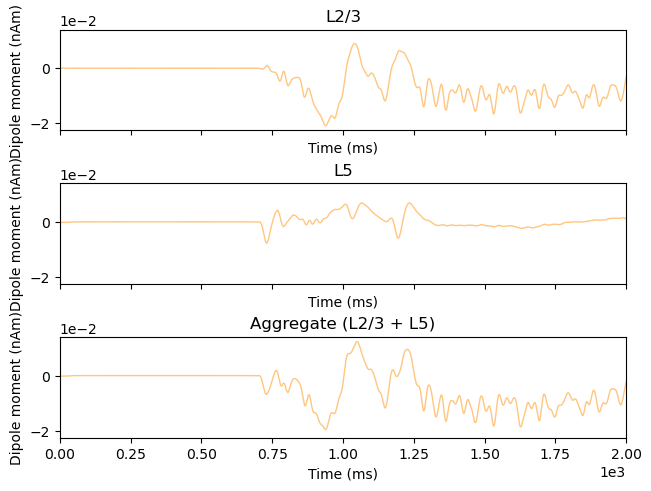

In [20]:
_=avg_dpl_init.plot(layer=['L2', 'L5', 'agg'],show=False, color='darkorange')

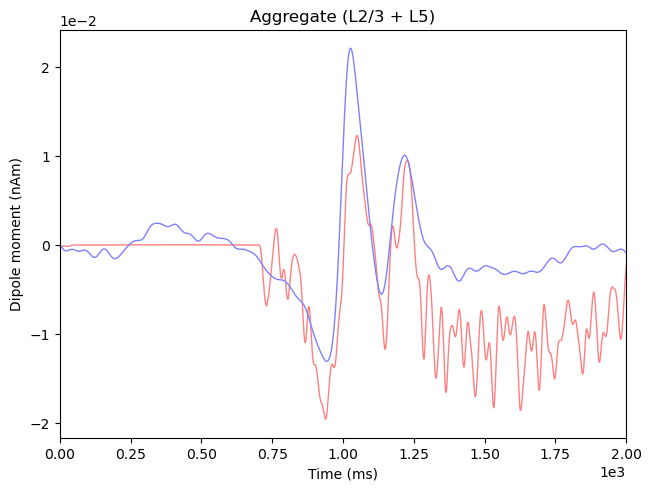

In [21]:
fig=avg_dpl_init.plot(layer=['agg'],show=False,color='red')
ax=plt.gca()
_ = exp_dpl.plot(ax=ax,color='blue')

/home/sgailhard/miniconda3/envs/hnn/lib/python3.12/site-packages/hnn_core/parallel_backends.py:891: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


******* Optimizing rydist1 ************
Setting parameters: {'rydist1_ampa_L2_basket': 0.0011, 'rydist1_ampa_L2_pyramidal': 0.0027, 'rydist1_ampa_L5_pyramidal': 0.0028, 'rydist1_mu': 734.0, 'rydist1_sigma': 57.6, 'evdist2_ampa_L2_basket': 0.7218195372927284, 'evdist2_ampa_L2_pyramidal': 0.855865923920232, 'evdist2_ampa_L5_pyramidal': 0.4895607289995994, 'evdist2_nmda_L2_basket': 0.0251579141124271, 'evdist2_nmda_L2_pyramidal': 0.1889054321596387, 'evdist2_nmda_L5_pyramidal': 0.6511264038381903, 'evdist2_mu': 906.0792312959826, 'evdist2_sigma': 31.86336962590867, 'evprox1_ampa_L2_basket': 0.6840319787921757, 'evprox1_ampa_L2_pyramidal': 0.7695926138554221, 'evprox1_ampa_L5_basket': 0.673643475417155, 'evprox1_ampa_L5_pyramidal': 0.6074167116013955, 'evprox1_nmda_L2_basket': 0.5404194014834149, 'evprox1_nmda_L2_pyramidal': 0.44588964185160007, 'evprox1_nmda_L5_basket': 0.7514578966690277, 'evprox1_nmda_L5_pyramidal': 0.36928292678740915, 'evprox1_mu': 1012.7828229477271, 'evprox1_sigma':

/home/sgailhard/Documents/laminar_meg/hnn_MERF/github-pipeline_merf_hnn/custom_optim.py:488: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show(show)


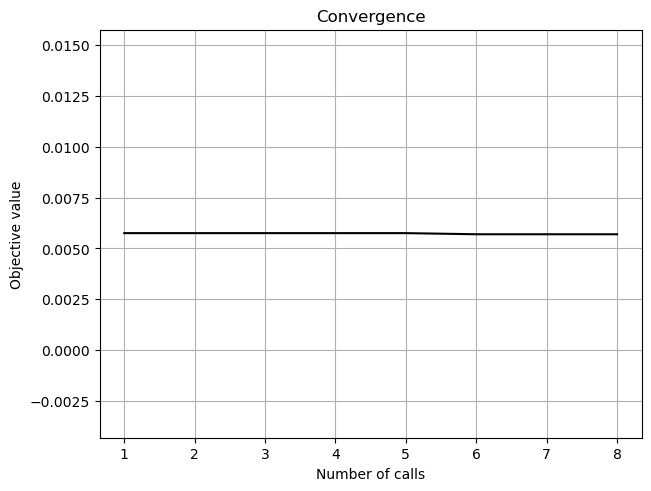

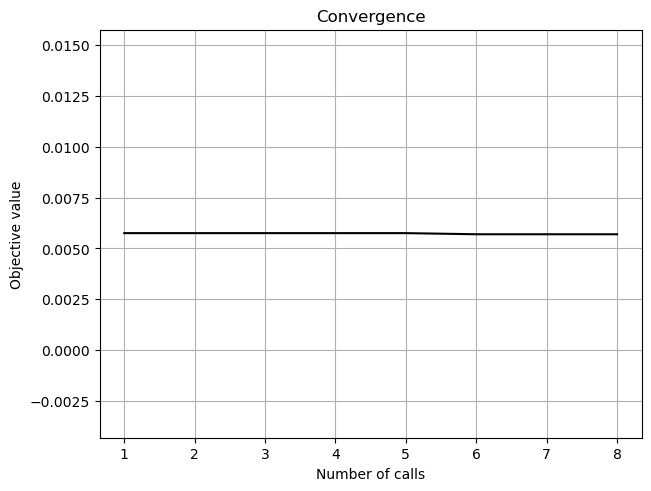

In [42]:
net=law_2021_model()
drives_to_optimize = ['rydist1','evdist2', 'evprox1', 'evprox2']
optim = SequentialOptimizer(net, tstop, n_trials, constraints, set_params, solver='bayesian', max_iter_per_drive=2)
with MPIBackend(n_procs=30, mpi_cmd='mpiexec'):
    optim.fit(initial_params=initial_params, drives_to_optimize = drives_to_optimize,
              target=exp_dpl, scale_factor=scaling_factor, smooth_window_len=window_len)
opt_params = dict(zip(constraints.keys(), optim.opt_params_))
optim.plot_convergence()

#### Vizualization
First load the optimized dipole you want to plot

In [26]:
opt_params_fname = os.path.join(hnn_dir, f'{subject}_{session}_c{c_idx}_{epoch}_erf_opt_params.json')

In [27]:
with open(opt_params_fname, 'w') as f:
    json.dump(opt_params, f)

In [28]:
with open(opt_params_fname, 'r') as f:
    opt_params = json.load(f)

In [29]:
optim_net = law_2021_model()
optim_net = set_params(optim_net, opt_params)

Setting parameters: {'rydist1_ampa_L2_basket': 0.0011, 'rydist1_ampa_L2_pyramidal': 0.0027, 'rydist1_ampa_L5_pyramidal': 0.0028, 'rydist1_mu': 734.0, 'rydist1_sigma': 57.6, 'evdist2_ampa_L2_basket': 0.7218195372927284, 'evdist2_ampa_L2_pyramidal': 0.855865923920232, 'evdist2_ampa_L5_pyramidal': 0.4895607289995994, 'evdist2_nmda_L2_basket': 0.0251579141124271, 'evdist2_nmda_L2_pyramidal': 0.1889054321596387, 'evdist2_nmda_L5_pyramidal': 0.6511264038381903, 'evdist2_mu': 906.0792312959826, 'evdist2_sigma': 31.86336962590867, 'evprox1_ampa_L2_basket': 0.6840319787921757, 'evprox1_ampa_L2_pyramidal': 0.7695926138554221, 'evprox1_ampa_L5_basket': 0.673643475417155, 'evprox1_ampa_L5_pyramidal': 0.6074167116013955, 'evprox1_nmda_L2_basket': 0.5404194014834149, 'evprox1_nmda_L2_pyramidal': 0.44588964185160007, 'evprox1_nmda_L5_basket': 0.7514578966690277, 'evprox1_nmda_L5_pyramidal': 0.36928292678740915, 'evprox1_mu': 1012.7828229477271, 'evprox1_sigma': 10.770710947808302, 'evprox2_ampa_L2_ba

In [30]:
with MPIBackend(n_procs=50, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim_net, tstop=tstop, n_trials=n_trials)

for dpl in opt_dpl:
    dpl.smooth(window_len).scale(scaling_factor)

avg_dpl_opt = average_dipoles(opt_dpl)

/home/sgailhard/miniconda3/envs/hnn/lib/python3.12/site-packages/hnn_core/parallel_backends.py:891: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


MPI will run 5 trial(s) sequentially by distributing network neurons over 50 processes.
numprocs=50
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWar

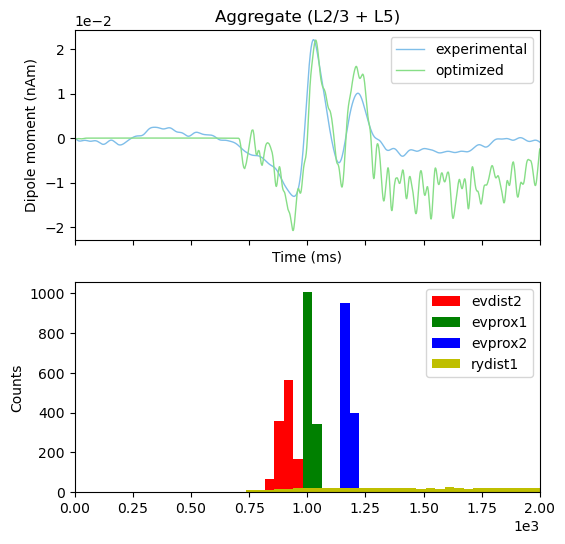

In [31]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

# plot original
exp_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:blue')
avg_dpl_opt.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].legend(['experimental','optimized'])
optim_net.cell_response.plot_spikes_hist(ax=axes[1])

plt.show()

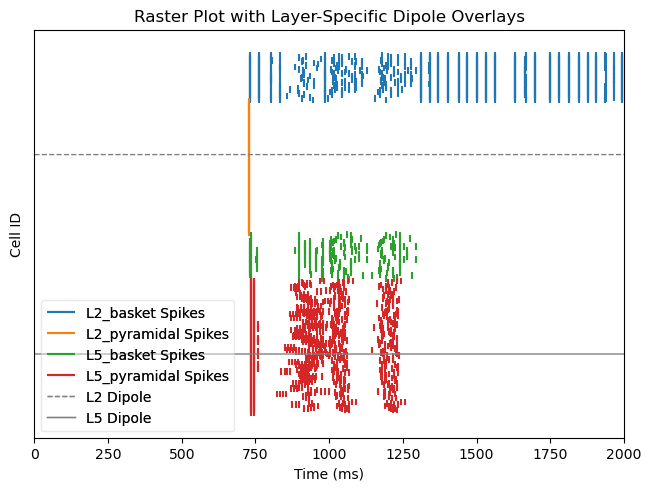

In [39]:
_ = optim_net.cell_response.plot_spikes_raster(trial_idx=0, dpl=opt_dpl[0], overlay_dipoles=True)

Laminar contributions

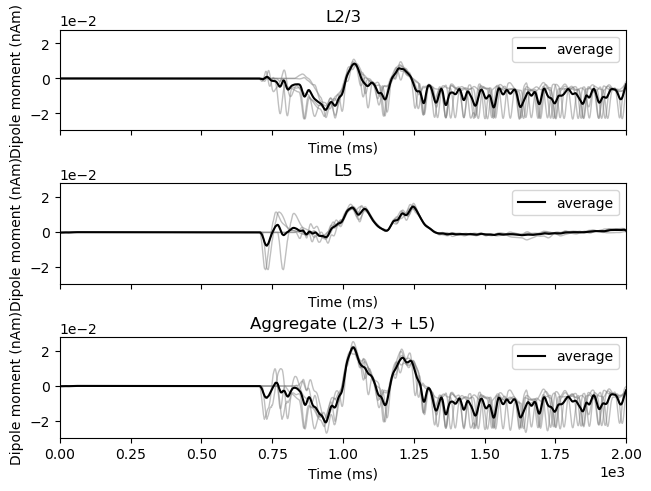

In [40]:
_ = plot_dipole(opt_dpl, average=True, layer=['L2', 'L5', 'agg'], show=False)